Google Natural Questions Data Clean

In [2]:
import json
import pandas as pd
import numpy as np

with open (r"/content/drive/MyDrive/train30k.json", 'r', errors='ignore') as f:
    data_dict = json.load(f)

len(data_dict)

final_nq_df = pd.json_normalize(data_dict, 'annotations',['document_text','question_text'], errors='ignore')

In [3]:
len(data_dict)

30000

In [4]:
final_nq_df.head()

,yes_no_answer,short_answers,annotation_id,long_answer.start_token,long_answer.candidate_index,long_answer.end_token,document_text,question_text
0,NONE,"[{'start_token': 1960, 'end_token': 1969}]",593165450220027640,1952,54,2019,Email marketing - Wikipedia <H1> Email marketi...,which is the most common use of opt-in e-mail ...
1,NONE,"[{'start_token': 213, 'end_token': 215}]",12034874153783787365,212,15,310,The Mother ( How I Met Your Mother ) - wikiped...,how i.met your mother who is the mother
2,NONE,[],10527123009892725162,319,24,438,Human fertilization - wikipedia <H1> Human fer...,what type of fertilisation takes place in humans
3,NONE,"[{'start_token': 512, 'end_token': 514}]",14634796365152556576,509,59,576,List of National Football League career quarte...,who had the most wins in the nfl
4,NONE,[],11038549994888625916,-1,-1,-1,Roanoke Colony - wikipedia <H1> Roanoke Colony...,what happened to the lost settlement of roanoke


In [5]:
# pull out the start and end tokens
def start_token(column):
    x = column.short_answers
    if len(x) ==0:
      return ''
    else:
      return x[0]['start_token']

def end_token(column):
    x = column.short_answers
    if len(x) ==0:
      return ''
    else:
      return x[0]['end_token']

final_nq_df['short_answers_start_token'] = final_nq_df[['short_answers']].apply(start_token, axis=1)
final_nq_df['short_answers_end_token'] = final_nq_df[['short_answers']].apply(end_token, axis=1)

In [6]:
# parse for short answers
def short_answer_func(x):
  if x.short_answers_start_token != '':
    start = int(x.short_answers_start_token)
    end = int(x.short_answers_end_token)
    tokenize = x.document_text.split(' ')[start:end]
  else: 
    tokenize = ''
  return tokenize


final_nq_df['short_answer'] = final_nq_df[['short_answers_start_token','short_answers_end_token','document_text']].apply(short_answer_func, axis=1)

In [7]:
# parse long answers
# parse for long and short answers
def long_answer_func(x):
  if x['long_answer.start_token'] != '':
    start = int(x['long_answer.start_token'])
    end = int(x['long_answer.end_token'])
    tokenize = x.document_text.split(' ')[start:end]
  else: 
    tokenize = ''
  return tokenize


final_nq_df['long_answer'] = final_nq_df[['long_answer.start_token','long_answer.end_token','document_text']].apply(long_answer_func, axis=1)

In [8]:
final_nq_df.head()

,yes_no_answer,short_answers,annotation_id,long_answer.start_token,long_answer.candidate_index,long_answer.end_token,document_text,question_text,short_answers_start_token,short_answers_end_token,short_answer,long_answer
0,NONE,"[{'start_token': 1960, 'end_token': 1969}]",593165450220027640,1952,54,2019,Email marketing - Wikipedia <H1> Email marketi...,which is the most common use of opt-in e-mail ...,1960,1969,"[a, newsletter, sent, to, an, advertising, fir...","[<P>, A, common, example, of, permission, mark..."
1,NONE,"[{'start_token': 213, 'end_token': 215}]",12034874153783787365,212,15,310,The Mother ( How I Met Your Mother ) - wikiped...,how i.met your mother who is the mother,213,215,"[Tracy, McConnell]","[<P>, Tracy, McConnell, ,, better, known, as, ..."
2,NONE,[],10527123009892725162,319,24,438,Human fertilization - wikipedia <H1> Human fer...,what type of fertilisation takes place in humans,,,,"[<P>, The, process, of, fertilization, involve..."
3,NONE,"[{'start_token': 512, 'end_token': 514}]",14634796365152556576,509,59,576,List of National Football League career quarte...,who had the most wins in the nfl,512,514,"[Tom, Brady]","[<P>, Active, quarterback, Tom, Brady, holds, ..."
4,NONE,[],11038549994888625916,-1,-1,-1,Roanoke Colony - wikipedia <H1> Roanoke Colony...,what happened to the lost settlement of roanoke,,,,[]


In [9]:
# find how many yes-no answers
final_nq_df['yes_no_answer'].value_counts()

NONE    29609
YES       235
NO        156
Name: yes_no_answer, dtype: int64

In [10]:
# remove all the yes-no answers
final_v0 = final_nq_df.loc[final_nq_df['yes_no_answer'] == 'NONE']

In [11]:
# clean the document text by keeping only the paragraph text
import re
def check_long(text):
  if '<P>' in text:
    paragraph = 1
  else:
    paragraph = 0
  return paragraph

final_v0['long_answer_paragraph'] = final_v0['long_answer'].apply(check_long)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [12]:
# remove all long answers that are not paragraphs <P> or is blank
final_v1 = final_v0.loc[final_v0['long_answer_paragraph'] == 1]

In [13]:
# get the number of examples 
final_v1['annotation_id'].count()

10991

In [14]:
# clean the document text by keeping only the paragraph text
import re
def clean_document_text(text):
  context = re.findall(r'<P>(.*?)\</P>', text)
  return context

final_v1['document_text_clean'] = final_v1['document_text'].apply(clean_document_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [15]:
final_v1.head(1)

,yes_no_answer,short_answers,annotation_id,long_answer.start_token,long_answer.candidate_index,long_answer.end_token,document_text,question_text,short_answers_start_token,short_answers_end_token,short_answer,long_answer,long_answer_paragraph,document_text_clean
0,NONE,"[{'start_token': 1960, 'end_token': 1969}]",593165450220027640,1952,54,2019,Email marketing - Wikipedia <H1> Email marketi...,which is the most common use of opt-in e-mail ...,1960,1969,"[a, newsletter, sent, to, an, advertising, fir...","[<P>, A, common, example, of, permission, mark...",1,[ Email marketing is the act of sending a comm...


In [16]:
# clean the long answer text
import re
def clean_answer_text(text):
  context = re.sub(r'<.*?>','', text)
  return context

In [17]:
# function to convert the list to string
def list_to_string(column):
  return ' '.join(column)

final_v1['long_answer'] = final_v1.apply(lambda x:list_to_string(x['long_answer']), axis=1)
final_v1['short_answer'] = final_v1.apply(lambda x:list_to_string(x['short_answer']), axis=1)
final_v1['document_text_clean'] = final_v1.apply(lambda x:list_to_string(x['document_text_clean']), axis=1)

# apply the special token drop to long answer as well
final_v1['long_answer_clean'] = final_v1['long_answer'].apply(clean_answer_text)
final_v1['short_answer_clean'] = final_v1['short_answer'].apply(clean_answer_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [18]:
# verify that it is working correctly. Note that the text is in a list
pd.set_option('display.max_colwidth', 20)
final_v1.head(10)

,yes_no_answer,short_answers,annotation_id,long_answer.start_token,long_answer.candidate_index,long_answer.end_token,document_text,question_text,short_answers_start_token,short_answers_end_token,short_answer,long_answer,long_answer_paragraph,document_text_clean,long_answer_clean,short_answer_clean
0,NONE,[{'start_token':...,593165450220027640,1952,54,2019,Email marketing ...,which is the mos...,1960,1969,a newsletter sen...,<P> A common exa...,1,Email marketing...,A common exampl...,a newsletter sen...
1,NONE,[{'start_token':...,1203487415378378...,212,15,310,The Mother ( How...,how i.met your m...,213,215,Tracy McConnell,<P> Tracy McConn...,1,Tracy McConnell...,Tracy McConnell...,Tracy McConnell
2,NONE,[],1052712300989272...,319,24,438,Human fertilizat...,what type of fer...,,,,<P> The process ...,1,Human fertiliza...,The process of ...,
3,NONE,[{'start_token':...,1463479636515255...,509,59,576,List of National...,who had the most...,512,514,Tom Brady,<P> Active quart...,1,The following i...,Active quarterb...,Tom Brady
6,NONE,[{'start_token':...,1264476247828562...,82,7,169,Pom Klementieff ...,who played manti...,83,85,Pom Klementieff,<P> Pom Klementi...,1,Pom Klementieff...,Pom Klementieff...,Pom Klementieff
8,NONE,[],1662966386021845...,562,3,695,History of the A...,what indian trib...,,,,<P> The survival...,1,The Acadians ( ...,The survival of...,
15,NONE,[{'start_token':...,1410875907948623...,675,13,874,Nashville sound ...,the nashville so...,758,777,the use of lush ...,<P> In the early...,1,The Nashville s...,In the early 19...,the use of lush ...
20,NONE,[],1309366052343798...,136,8,288,Java development...,what is the use ...,,,,<P> The Java Dev...,1,The Java Develo...,The Java Develo...,
21,NONE,[{'start_token':...,1214701669005018...,4240,80,4282,Learner 's permi...,who needs to be ...,4255,4280,an adult license...,"<P> Typically , ...",1,A driver 's per...,"Typically , a d...",an adult license...
22,NONE,[{'start_token':...,7714113395991537822,321,24,393,God 's Not Dead ...,god's not dead a...,343,347,"March 30 , 2018",<P> Principal ph...,1,God 's Not Dead...,Principal photo...,"March 30 , 2018"


In [19]:
# # pulling the short answer from the long answer clean

# def long_answer_token(line):
#   if line.short_answer_clean != '':
#     short_tokenize = line.short_answer_clean.split(' ')
#     num = len(short_tokenize)
#     long_tokenize = line.long_answer_clean.split(' ')
#     for i in range(len(long_tokenize)):
#       word = long_tokenize[i]
#       if word == short_tokenize[0]:
#         # then get the answer by number of tokens from long answer and see if it matches
#         ending_token = i+num
#         answer = long_tokenize[i:ending_token]
#         if answer == short_tokenize:
#           # print(answer)
#           token = i
#           break
#   else: 
#     token = ''
#   #  token = long_answer.find(short_answer)
#   return (token)
# final_v1['long_answer_start'] = final_v1[['long_answer_clean','short_answer_clean']].apply(long_answer_token, axis=1)

In [20]:
# calculate the start token for the short answer within the long answer context
def long_answer_token(line):
  if line.short_answer_clean != '':
    short_tokenize = list(map(lambda i:i, line.short_answer_clean))
    num = len(short_tokenize)
    long_tokenize = list(map(lambda i:i, line.long_answer_clean))
    for i in range(len(long_tokenize)):
      word = long_tokenize[i]
      if word == short_tokenize[0]:
        # then get the answer by number of tokens from long answer and see if it matches
        ending_token = i+num
        answer = long_tokenize[i:ending_token]
        if answer == short_tokenize:
          # print(answer)
          token = i
          break
  else: 
    token = ''

  return (token)
final_v1['short_answer_start_long_answer'] = final_v1[['long_answer_clean','short_answer_clean']].apply(long_answer_token, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
# calculate the start token for the long answer within the document context
def document_long_answer_token(line):
  token = ''
  if line.long_answer_clean != '':
    long_tokenize = list(map(lambda i:i, line.long_answer_clean))
    num = len(long_tokenize)
    document_tokenize =list(map(lambda i:i, line.document_text_clean))
    for i in range(len(document_tokenize)):
      word = document_tokenize[i]
      if word == long_tokenize[0]:
        # then get the answer by number of tokens from long answer and see if it matches
        ending_token = i+num
        answer = document_tokenize[i:ending_token]
        if answer == long_tokenize:
          # print("answer:" ,answer)
          token = i
          break
  else: 
    token = ''
  return (token)

final_v1['long_answer_start_document'] = final_v1[['document_text_clean','long_answer_clean']].apply(document_long_answer_token, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
# there are long answers that are in table format. They have been assigned '' by the code above
# remove all examples that have answers in table format
final_v2 = final_v1.loc[final_v1['long_answer_start_document'] != '']

In [23]:
# get the number of examples. should be 10991 - 383 = 10608 
final_v2['annotation_id'].count()

10608

In [24]:
# calculate the start token for the short answer within the document context
def document_short_answer_token(line):
  if line.short_answer_clean != '':
    long_tokenize = list(map(lambda i:i, line.short_answer_clean))
    num = len(long_tokenize)
    document_tokenize = list(map(lambda i:i, line.document_text_clean))
    for i in range(len(document_tokenize)):
      word = document_tokenize[i]
      if word == long_tokenize[0]:
        # then get the answer by number of tokens from long answer and see if it matches
        ending_token = i+num
        answer = document_tokenize[i:ending_token]
        if answer == long_tokenize:
          # print("answer:" ,answer)
          token = i
          break
  else: 
    token = ''
  return (token)

final_v2['short_answer_start_document'] = final_v2[['document_text_clean','short_answer_clean']].apply(document_short_answer_token, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
pd.set_option('display.max_colwidth', 20)
final_v2.head(10)

,yes_no_answer,short_answers,annotation_id,long_answer.start_token,long_answer.candidate_index,long_answer.end_token,document_text,question_text,short_answers_start_token,short_answers_end_token,short_answer,long_answer,long_answer_paragraph,document_text_clean,long_answer_clean,short_answer_clean,short_answer_start_long_answer,long_answer_start_document,short_answer_start_document
0,NONE,[{'start_token':...,593165450220027640,1952,54,2019,Email marketing ...,which is the mos...,1960,1969,a newsletter sen...,<P> A common exa...,1,Email marketing...,A common exampl...,a newsletter sen...,45,6907,6952
1,NONE,[{'start_token':...,1203487415378378...,212,15,310,The Mother ( How...,how i.met your m...,213,215,Tracy McConnell,<P> Tracy McConn...,1,Tracy McConnell...,Tracy McConnell...,Tracy McConnell,1,0,1
2,NONE,[],1052712300989272...,319,24,438,Human fertilizat...,what type of fer...,,,,<P> The process ...,1,Human fertiliza...,The process of ...,,,321,
3,NONE,[{'start_token':...,1463479636515255...,509,59,576,List of National...,who had the most...,512,514,Tom Brady,<P> Active quart...,1,The following i...,Active quarterb...,Tom Brady,20,194,214
6,NONE,[{'start_token':...,1264476247828562...,82,7,169,Pom Klementieff ...,who played manti...,83,85,Pom Klementieff,<P> Pom Klementi...,1,Pom Klementieff...,Pom Klementieff...,Pom Klementieff,1,0,1
8,NONE,[],1662966386021845...,562,3,695,History of the A...,what indian trib...,,,,<P> The survival...,1,The Acadians ( ...,The survival of...,,,1754,
15,NONE,[{'start_token':...,1410875907948623...,675,13,874,Nashville sound ...,the nashville so...,758,777,the use of lush ...,<P> In the early...,1,The Nashville s...,In the early 19...,the use of lush ...,465,2713,3178
20,NONE,[],1309366052343798...,136,8,288,Java development...,what is the use ...,,,,<P> The Java Dev...,1,The Java Develo...,The Java Develo...,,,0,
21,NONE,[{'start_token':...,1214701669005018...,4240,80,4282,Learner 's permi...,who needs to be ...,4255,4280,an adult license...,"<P> Typically , ...",1,A driver 's per...,"Typically , a d...",an adult license...,80,16127,16207
22,NONE,[{'start_token':...,7714113395991537822,321,24,393,God 's Not Dead ...,god's not dead a...,343,347,"March 30 , 2018",<P> Principal ph...,1,God 's Not Dead...,Principal photo...,"March 30 , 2018",122,379,501


In [26]:
############## NOTE #######################
# the document_text_clean and the long_answer_clean have a space at the beginning of text
# if there are issues with the tokenization being off, check these columns

In [27]:
# Run tests to verify that the start token is correct for the 
num = 3
document = final_v2['document_text_clean'][num]
long_answer = final_v2["long_answer_clean"][num]
short_answer = final_v2["short_answer_clean"][num]
split_doc = list(map(lambda i:i, document))
start_doc = final_v2['short_answer_start_document'][num]
split_long = list(map(lambda i:i, long_answer))
start_long = final_v2['short_answer_start_long_answer'][num]

In [28]:
short_answer

'Tom Brady'

In [29]:
split_doc[start_doc:start_doc+10]

['T', 'o', 'm', ' ', 'B', 'r', 'a', 'd', 'y', ' ']

In [30]:
split_long[start_long:start_long+10]

['T', 'o', 'm', ' ', 'B', 'r', 'a', 'd', 'y', ' ']

In [31]:
# id needs to be changed from float to string
final_v2['annotation_id'] = final_v2['annotation_id'].astype(str) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
# set final dataset
final_nq = final_v2

Create Natural Questions Datasets

Question Generation Dataset

In [ ]:
# create question generation dataset
# import pandas as pd
nq_question_generation = final_nq[['short_answer_start_long_answer','short_answer_clean','long_answer_clean','annotation_id','question_text']]

In [ ]:
nq_question_generation.head()

,short_answer_start_long_answer,short_answer_clean,long_answer_clean,annotation_id,question_text
0,45,a newsletter sen...,A common exampl...,593165450220027640,which is the mos...
1,1,Tracy McConnell,Tracy McConnell...,1203487415378378...,how i.met your m...
2,,,The process of ...,1052712300989272...,what type of fer...
3,20,Tom Brady,Active quarterb...,1463479636515255...,who had the most...
6,1,Pom Klementieff,Pom Klementieff...,1264476247828562...,who played manti...


In [ ]:
# verify the count
nq_question_generation['annotation_id'].count()

10608

In [ ]:
# count the number of examples that do not have a short answer (2585 of 10608)
(nq_question_generation['short_answer_clean'].values == '').sum() 

2585

In [ ]:
# function to combine the start token and answer into dictionary
def to_dict(answer_start, answer):
  if answer_start != '':
    answer_start_lst= []
    answer_start_lst.append(answer_start)
    answer_lst = []
    answer_lst.append(answer)  
    dict = {}
    dict['answer_start'] = answer_start_lst
    dict['text'] = answer_lst
  else:
    dict = {}
    dict['answer_start'] = []
    dict['text'] = []
  return dict

In [ ]:
# run function
nq_question_generation['answers'] = nq_question_generation.apply(lambda x:to_dict(x['short_answer_start_long_answer'],x['short_answer_clean']), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
pd.set_option('display.max_colwidth', 50)
nq_question_generation.head(10)

,short_answer_start_long_answer,short_answer_clean,long_answer_clean,annotation_id,question_text,answers
0,45,a newsletter sent to an advertising firm 's cu...,A common example of permission marketing is a...,593165450220027640,which is the most common use of opt-in e-mail ...,"{'answer_start': [45], 'text': ['a newsletter ..."
1,1,Tracy McConnell,"Tracy McConnell , better known as `` The Moth...",12034874153783787365,how i.met your mother who is the mother,"{'answer_start': [1], 'text': ['Tracy McConnel..."
2,,,The process of fertilization involves a sperm...,10527123009892725162,what type of fertilisation takes place in humans,"{'answer_start': [], 'text': []}"
3,20,Tom Brady,Active quarterback Tom Brady holds the record...,14634796365152556576,who had the most wins in the nfl,"{'answer_start': [20], 'text': ['Tom Brady']}"
6,1,Pom Klementieff,Pom Klementieff ( born 3 May 1986 ) is a Fren...,12644762478285625867,who played mantis guardians of the galaxy 2,"{'answer_start': [1], 'text': ['Pom Klementief..."
8,,,The survival of the Acadian settlements was b...,16629663860218450498,what indian tribe did the acadians form friend...,"{'answer_start': [], 'text': []}"
15,465,the use of lush string arrangements with a rea...,"In the early 1960s , the Nashville sound bega...",14108759079486238020,the nashville sound brought a polished and cos...,"{'answer_start': [465], 'text': ['the use of l..."
20,,,The Java Development Kit ( JDK ) is an implem...,13093660523437988115,what is the use of jdk in java,"{'answer_start': [], 'text': []}"
21,80,an adult licensed driver who is at least 21 ye...,"Typically , a driver operating with a learner...",12147016690050182988,who needs to be in the car with a permit driver,"{'answer_start': [80], 'text': ['an adult lice..."
22,122,"March 30 , 2018",Principal photography was completed in Little...,7714113395991537822,god's not dead a light in the darkness release...,"{'answer_start': [122], 'text': ['March 30 , 2..."


In [ ]:
######## insert code to split the data into 66/33 split of answerable to unanswerable questions




In [ ]:
df_nq = nq_question_generation[['answers','long_answer_clean','annotation_id','question_text']]
df_nq = df_nq.rename(columns={"long_answer_clean": "context", "question_text": "question", "annotation_id": "id"})

In [ ]:
df_nq.head()

,answers,context,id,question
0,"{'answer_start': [45], 'text': ['a newsletter ...",A common example of permission marketing is a...,593165450220027640,which is the most common use of opt-in e-mail ...
1,"{'answer_start': [1], 'text': ['Tracy McConnel...","Tracy McConnell , better known as `` The Moth...",12034874153783787365,how i.met your mother who is the mother
2,"{'answer_start': [], 'text': []}",The process of fertilization involves a sperm...,10527123009892725162,what type of fertilisation takes place in humans
3,"{'answer_start': [20], 'text': ['Tom Brady']}",Active quarterback Tom Brady holds the record...,14634796365152556576,who had the most wins in the nfl
6,"{'answer_start': [1], 'text': ['Pom Klementief...",Pom Klementieff ( born 3 May 1986 ) is a Fren...,12644762478285625867,who played mantis guardians of the galaxy 2


In [ ]:
# split into train and validation sets
from sklearn.model_selection import train_test_split

train, validation = train_test_split(df_nq, test_size=0.2)

In [ ]:
train.count()

answers     8486
context     8486
id          8486
question    8486
dtype: int64

In [ ]:
validation.count()

answers     2122
context     2122
id          2122
question    2122
dtype: int64

In [ ]:
validation.to_json('/content/drive/MyDrive/ColabNotebooks/data/nq-qg_validation.jsonl',orient='records', lines=True)

In [ ]:
train.to_json('/content/drive/MyDrive/ColabNotebooks/data/nq-qg_train.jsonl',orient='records', lines=True)

Context Length Dataset

In [ ]:
# create context length dataset
# import pandas as pd
nq_context_length = final_nq[['short_answer_start_document','short_answer_clean','document_text_clean','annotation_id','question_text']]

In [ ]:
nq_context_length.head()

,short_answer_start_document,short_answer_clean,document_text_clean,annotation_id,question_text
0,6952,a newsletter sent to an advertising firm 's cu...,Email marketing is the act of sending a comme...,593165450220027640,which is the most common use of opt-in e-mail ...
1,1,Tracy McConnell,"Tracy McConnell , better known as `` The Moth...",12034874153783787365,how i.met your mother who is the mother
2,,,Human fertilization is the union of a human e...,10527123009892725162,what type of fertilisation takes place in humans
3,214,Tom Brady,The following is a list of the top National F...,14634796365152556576,who had the most wins in the nfl
6,1,Pom Klementieff,Pom Klementieff ( born 3 May 1986 ) is a Fren...,12644762478285625867,who played mantis guardians of the galaxy 2


In [ ]:
# count the number of examples that do not have context (they should all have a context)
(nq_context_length['document_text_clean'].values != '').sum() 

10608

In [ ]:
# count the number of examples that do not have a short answer (2585 of 10608)
(nq_context_length['short_answer_clean'].values == '').sum() 

2585

In [ ]:
# function to combine the start token and answer into dictionary
def to_dict(answer_start, answer):
  if answer_start != '':
    answer_start_lst= []
    answer_start_lst.append(answer_start)
    answer_lst = []
    answer_lst.append(answer)  
    dict = {}
    dict['answer_start'] = answer_start_lst
    dict['text'] = answer_lst
  else:
    dict = {}
    dict['answer_start'] = []
    dict['text'] = []
  return dict

In [ ]:
# run function
nq_context_length['answers'] = nq_context_length.apply(lambda x:to_dict(x['short_answer_start_document'],x['short_answer_clean']), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
pd.set_option('display.max_colwidth', 50)
nq_context_length.head()

,short_answer_start_document,short_answer_clean,document_text_clean,annotation_id,question_text,answers
0,6952,a newsletter sent to an advertising firm 's cu...,Email marketing is the act of sending a comme...,593165450220027640,which is the most common use of opt-in e-mail ...,"{'answer_start': [6952], 'text': ['a newslette..."
1,1,Tracy McConnell,"Tracy McConnell , better known as `` The Moth...",12034874153783787365,how i.met your mother who is the mother,"{'answer_start': [1], 'text': ['Tracy McConnel..."
2,,,Human fertilization is the union of a human e...,10527123009892725162,what type of fertilisation takes place in humans,"{'answer_start': [], 'text': []}"
3,214,Tom Brady,The following is a list of the top National F...,14634796365152556576,who had the most wins in the nfl,"{'answer_start': [214], 'text': ['Tom Brady']}"
6,1,Pom Klementieff,Pom Klementieff ( born 3 May 1986 ) is a Fren...,12644762478285625867,who played mantis guardians of the galaxy 2,"{'answer_start': [1], 'text': ['Pom Klementief..."


In [ ]:
######## insert code to split the data into 66/33 split of answerable to unanswerable questions



In [ ]:
df_cl = nq_context_length[['answers','document_text_clean','annotation_id','question_text']]
df_cl = df_cl.rename(columns={"document_text_clean": "context", "question_text": "question", "annotation_id": "id"})

In [ ]:
df_cl.head()

,answers,context,id,question
0,"{'answer_start': [6952], 'text': ['a newslette...",Email marketing is the act of sending a comme...,593165450220027640,which is the most common use of opt-in e-mail ...
1,"{'answer_start': [1], 'text': ['Tracy McConnel...","Tracy McConnell , better known as `` The Moth...",12034874153783787365,how i.met your mother who is the mother
2,"{'answer_start': [], 'text': []}",Human fertilization is the union of a human e...,10527123009892725162,what type of fertilisation takes place in humans
3,"{'answer_start': [214], 'text': ['Tom Brady']}",The following is a list of the top National F...,14634796365152556576,who had the most wins in the nfl
6,"{'answer_start': [1], 'text': ['Pom Klementief...",Pom Klementieff ( born 3 May 1986 ) is a Fren...,12644762478285625867,who played mantis guardians of the galaxy 2


In [ ]:
########## FOR TESTING  #################
# get sample of larger dataset
test = df_cl.sample(frac =.10)

In [ ]:
test.count()

answers     1061
context     1061
id          1061
question    1061
dtype: int64

In [ ]:
# split into train and validation sets
from sklearn.model_selection import train_test_split

train_cl, validation_cl = train_test_split(df_cl, test_size=0.2) ###change test to df_cl when ready

In [ ]:
train_cl.count()

answers     8486
context     8486
id          8486
question    8486
dtype: int64

In [ ]:
validation_cl.count()

answers     2122
context     2122
id          2122
question    2122
dtype: int64

In [ ]:
validation_cl.to_json('/content/drive/MyDrive/ColabNotebooks/data/nq-cl_validation.jsonl',orient='records', lines=True)

In [ ]:
train_cl.to_json('/content/drive/MyDrive/ColabNotebooks/data/nq-cl_train.jsonl',orient='records', lines=True)

# Context Length Reduction Dataset


In [33]:
nq_context_length_reduce = final_nq[['short_answer_start_document','short_answer_clean','document_text_clean','annotation_id','question_text']]

In [34]:
def tokenize(text):
  text_token = list(map(lambda i:i, text.document_text_clean))
  return len(text_token)

nq_context_length_reduce['document_length_token'] = nq_context_length_reduce[['document_text_clean']].apply(tokenize, axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [35]:
def find_p(line):
  if line.short_answer_end_document == 0:
    return -.1
  else:
    return int(line.short_answer_end_document)/int(line.document_length_token)

def tokenize(text):
  text_token = list(map(lambda i:i, text.short_answer_clean))
  return len(text_token)

# find the length of the short answer
nq_context_length_reduce['short_answer_length'] = nq_context_length_reduce[['short_answer_clean']].apply(tokenize, axis=1)

def end_short(line):
  if line.short_answer_start_document == '':
    return 0
  else:
    return int(line.short_answer_start_document) + int(line.short_answer_length)

nq_context_length_reduce['short_answer_end_document'] = nq_context_length_reduce[['short_answer_start_document','short_answer_length']].apply(end_short, axis=1)
nq_context_length_reduce['percent_loc_in_doc'] = nq_context_length_reduce[['short_answer_end_document','document_length_token']].apply(find_p, axis=1)
nq_context_length_reduce.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,short_answer_start_document,short_answer_clean,document_text_clean,annotation_id,question_text,document_length_token,short_answer_length,short_answer_end_document,percent_loc_in_doc
0,6952,a newsletter sen...,Email marketing...,593165450220027640,which is the mos...,11164,53,7005,0.627463
1,1,Tracy McConnell,Tracy McConnell...,1203487415378378...,how i.met your m...,12325,15,16,0.001298
2,,,Human fertiliza...,1052712300989272...,what type of fer...,7767,0,0,-0.100000
3,214,Tom Brady,The following i...,1463479636515255...,who had the most...,1957,9,223,0.113950
6,1,Pom Klementieff,Pom Klementieff...,1264476247828562...,who played manti...,4187,15,16,0.003821
8,,,The Acadians ( ...,1662966386021845...,what indian trib...,22964,0,0,-0.100000
15,3178,the use of lush ...,The Nashville s...,1410875907948623...,the nashville so...,4399,107,3285,0.746761
20,,,The Java Develo...,1309366052343798...,what is the use ...,2358,0,0,-0.100000
21,16207,an adult license...,A driver 's per...,1214701669005018...,who needs to be ...,19001,119,16326,0.859218
22,501,"March 30 , 2018",God 's Not Dead...,7714113395991537822,god's not dead a...,4267,15,516,0.120928


In [35]:
# nq_context_length_reduce.loc[nq_context_length_reduce['short_answer_end'] <= 0.5]

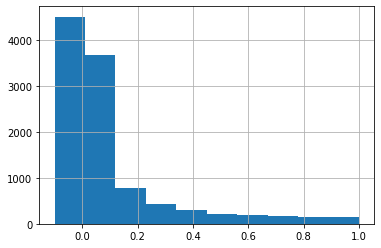

In [36]:
# the -1 represent answers with no context

nq_context_length_reduce['percent_loc_in_doc'].hist(bins=10)


In [37]:
nq_context_length_reduce.count()

short_answer_start_document    10608
short_answer_clean             10608
document_text_clean            10608
annotation_id                  10608
question_text                  10608
document_length_token          10608
short_answer_length            10608
short_answer_end_document      10608
percent_loc_in_doc             10608
dtype: int64

In [39]:

nq_context_length_reduce_final = nq_context_length_reduce.loc[nq_context_length_reduce['percent_loc_in_doc'] <= 0.1]
nq_context_length_reduce_final.count()

short_answer_start_document    7969
short_answer_clean             7969
document_text_clean            7969
annotation_id                  7969
question_text                  7969
document_length_token          7969
short_answer_length            7969
short_answer_end_document      7969
percent_loc_in_doc             7969
dtype: int64

In [38]:
nq_context_length_reduce_final['document_length_token'].sum()

183496088

In [40]:
import math

def new_context(line):
  # get how many tokens and divide by 2
  n = math.ceil(int(line.document_length_token) *0.1)
  token = list(map(lambda i:i, line.document_text_clean))[:n]
  return "".join(token)

nq_context_length_reduce_final['document_text_clean'] = nq_context_length_reduce_final[['document_text_clean','document_length_token']].apply(new_context, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [41]:
def tokenize(text):
  text_token = list(map(lambda i:i, text.document_text_clean))
  return len(text_token)

nq_context_length_reduce_final['document_length_token_half'] = nq_context_length_reduce_final[['document_text_clean']].apply(tokenize, axis=1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [42]:
nq_context_length_reduce_final['document_length_token_half'].sum()

15874126

In [43]:
nq_context_length_reduce_final.head()

,short_answer_start_document,short_answer_clean,document_text_clean,annotation_id,question_text,document_length_token,short_answer_length,short_answer_end_document,percent_loc_in_doc,document_length_token_half
1,1,Tracy McConnell,Tracy McConnell...,1203487415378378...,how i.met your m...,12325,15,16,0.001298,1233
2,,,Human fertiliza...,1052712300989272...,what type of fer...,7767,0,0,-0.100000,777
6,1,Pom Klementieff,Pom Klementieff...,1264476247828562...,who played manti...,4187,15,16,0.003821,419
8,,,The Acadians ( ...,1662966386021845...,what indian trib...,22964,0,0,-0.100000,2297
20,,,The Java Develo...,1309366052343798...,what is the use ...,2358,0,0,-0.100000,236


In [44]:
# function to combine the start token and answer into dictionary
def to_dict(answer_start, answer):
  if answer_start != '':
    answer_start_lst= []
    answer_start_lst.append(answer_start)
    answer_lst = []
    answer_lst.append(answer)  
    dict = {}
    dict['answer_start'] = answer_start_lst
    dict['text'] = answer_lst
  else:
    dict = {}
    dict['answer_start'] = []
    dict['text'] = []
  return dict

# run function
nq_context_length_reduce_final['answers'] = nq_context_length_reduce_final.apply(lambda x:to_dict(x['short_answer_start_document'],x['short_answer_clean']), axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:

df_cl_reduce = nq_context_length_reduce_final[['answers','document_text_clean','annotation_id','question_text']]
df_cl_reduce = df_cl_reduce.rename(columns={"document_text_clean": "context", "question_text": "question", "annotation_id": "id"})

In [46]:

pd.set_option('display.max_colwidth', 50)
df_cl_reduce.head()

,answers,context,id,question
1,"{'answer_start': [1], 'text': ['Tracy McConnel...","Tracy McConnell , better known as `` The Moth...",12034874153783787365,how i.met your mother who is the mother
2,"{'answer_start': [], 'text': []}",Human fertilization is the union of a human e...,10527123009892725162,what type of fertilisation takes place in humans
6,"{'answer_start': [1], 'text': ['Pom Klementief...",Pom Klementieff ( born 3 May 1986 ) is a Fren...,12644762478285625867,who played mantis guardians of the galaxy 2
8,"{'answer_start': [], 'text': []}",The Acadians ( French : Acadiens ) are the de...,16629663860218450498,what indian tribe did the acadians form friend...
20,"{'answer_start': [], 'text': []}",The Java Development Kit ( JDK ) is an implem...,13093660523437988115,what is the use of jdk in java


In [47]:
# split into train and validation sets
from sklearn.model_selection import train_test_split

train_cl_reduce, validation_cl_reduce = train_test_split(df_cl_reduce, test_size=0.2) ###change test to df_cl when ready

In [48]:
train_cl_reduce.count()

answers     6375
context     6375
id          6375
question    6375
dtype: int64

In [49]:
validation_cl_reduce.to_json('/content/drive/MyDrive/ColabNotebooks/data/nq-cl-reduce_10_validation.jsonl',orient='records', lines=True)

In [50]:
train_cl_reduce.to_json('/content/drive/MyDrive/ColabNotebooks/data/nq-cl-reduce_10_train.jsonl',orient='records', lines=True)


Doing 30% reduction and seeing what happens

In [51]:
(nq_context_length_reduce_final['short_answer_clean'].values == '').sum() 

2585

In [ ]:
nq_context_length_reduce_final = nq_context_length_reduce.loc[nq_context_length_reduce['percent_loc_in_doc'] <= 0.5]
nq_context_length_reduce_final.count()

In [ ]:
import math

def new_context(line):
  # get how many tokens and divide by 2
  n = math.ceil(int(line.document_length_token)*0.3)
  token = list(map(lambda i:i, line.document_text_clean))[:n]
  return "".join(token)

nq_context_length_reduce_final['document_text_clean'] = nq_context_length_reduce_final[['document_text_clean','document_length_token']].apply(new_context, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
def tokenize(text):
  text_token = list(map(lambda i:i, text.document_text_clean))
  return len(text_token)

nq_context_length_reduce_final['document_length_token_half'] = nq_context_length_reduce_final[['document_text_clean']].apply(tokenize, axis=1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
nq_context_length_reduce_final['document_length_token_half'].sum()

91750509

In [ ]:
nq_context_length_reduce_final.head()

,short_answer_start_document,short_answer_clean,document_text_clean,annotation_id,question_text,document_length_token,short_answer_length,short_answer_end_document,percent_loc_in_doc,document_length_token_half
1,1,Tracy McConnell,Tracy McConnell...,1203487415378378...,how i.met your m...,12325,15,16,0.001298,6163
2,,,Human fertiliza...,1052712300989272...,what type of fer...,7767,0,0,-0.100000,3884
3,214,Tom Brady,The following i...,1463479636515255...,who had the most...,1957,9,223,0.113950,979
6,1,Pom Klementieff,Pom Klementieff...,1264476247828562...,who played manti...,4187,15,16,0.003821,2094
8,,,The Acadians ( ...,1662966386021845...,what indian trib...,22964,0,0,-0.100000,11482


In [ ]:

pd.set_option('display.max_colwidth', None)
nq_context_length_reduce_final[nq_context_length_reduce_final['annotation_id']=='15201837892926249348']['document_text_clean']

20323       The First Transcontinental Railroad ( also called the Great Transcontinental Railroad , known originally as the `` Pacific Railroad '' and later as the `` Overland Route '' ) was a 1,912 - mile ( 3,077 km ) continuous railroad line constructed between 1863 and 1869 that connected the existing eastern U.S. rail network at Omaha , Nebraska / Council Bluffs , Iowa with the Pacific coast at the Oakland Long Wharf on San Francisco Bay . The rail line was built by three private companies over public lands provided by extensive US land grants . Construction was financed by both state and US government subsidy bonds as well as by company issued mortgage bonds . The Western Pacific Railroad Company built 132 mi ( 212 km ) of track from Oakland / Alameda to Sacramento , California . The Central Pacific Railroad Company of California ( CPRR ) constructed 690 mi ( 1,110 km ) eastward from Sacramento to Promontory Summit , Utah Territory ( U.T. ) . The Union Pacific built 1,085 mi ( 1,7

In [ ]:
# function to combine the start token and answer into dictionary
def to_dict(answer_start, answer):
  if answer_start != '':
    answer_start_lst= []
    answer_start_lst.append(answer_start)
    answer_lst = []
    answer_lst.append(answer)  
    dict = {}
    dict['answer_start'] = answer_start_lst
    dict['text'] = answer_lst
  else:
    dict = {}
    dict['answer_start'] = []
    dict['text'] = []
  return dict

# run function
nq_context_length_reduce_final['answers'] = nq_context_length_reduce_final.apply(lambda x:to_dict(x['short_answer_start_document'],x['short_answer_clean']), axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:

df_cl_reduce = nq_context_length_reduce_final[['answers','document_text_clean','annotation_id','question_text']]
df_cl_reduce = df_cl_reduce.rename(columns={"document_text_clean": "context", "question_text": "question", "annotation_id": "id"})

In [ ]:

pd.set_option('display.max_colwidth', 50)
df_cl_reduce.head()

,answers,context,id,question
1,"{'answer_start': [1], 'text': ['Tracy McConnel...","Tracy McConnell , better known as `` The Moth...",12034874153783787365,how i.met your mother who is the mother
2,"{'answer_start': [], 'text': []}",Human fertilization is the union of a human e...,10527123009892725162,what type of fertilisation takes place in humans
3,"{'answer_start': [214], 'text': ['Tom Brady']}",The following is a list of the top National F...,14634796365152556576,who had the most wins in the nfl
6,"{'answer_start': [1], 'text': ['Pom Klementief...",Pom Klementieff ( born 3 May 1986 ) is a Fren...,12644762478285625867,who played mantis guardians of the galaxy 2
8,"{'answer_start': [], 'text': []}",The Acadians ( French : Acadiens ) are the de...,16629663860218450498,what indian tribe did the acadians form friend...


In [ ]:
# split into train and validation sets
from sklearn.model_selection import train_test_split

train_cl_reduce, validation_cl_reduce = train_test_split(df_cl_reduce, test_size=0.2) ###change test to df_cl when ready

In [ ]:
train_cl_reduce.count()

answers     7856
context     7856
id          7856
question    7856
dtype: int64

In [ ]:
validation_cl_reduce.to_json('/content/drive/MyDrive/ColabNotebooks/data/nq-cl-reduce_validation.jsonl',orient='records', lines=True)

In [ ]:
train_cl_reduce.to_json('/content/drive/MyDrive/ColabNotebooks/data/nq-cl-reduce_train.jsonl',orient='records', lines=True)